# Basic Regression Analysis

This was a basic regression analysis performed on a set of questionnaire results. The aim of this was to determine the accuracy of the test in predicting knowledge of the participants on the subject matter and comparing it with the age of participants. For my purposes, the participants and subject matter were left ambiguous.

The questions were designed with multiple options and participants were asked to select all true statements for each question. All questions required selecting at least one true statement.

My aim was to either prove or refute that the questionnaire showed a strong correlation between age and knowledge of the subject matter. In order to prove this, we will be looking for a RSE greater than 0.7.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Read in our questionnaire data
df = pd.read_csv('questionnaire_results.csv')

# The file contains a number of empty rows with no data. We need to remove these to clean up the dataset.
df.dropna(subset=['age_v2'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25 entries, 0 to 52
Data columns (total 84 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   record_id   25 non-null     float64
 1   age_v2      25 non-null     float64
 2   q1_v2___1   25 non-null     float64
 3   q1_v2___2   25 non-null     float64
 4   q1_v2___3   25 non-null     float64
 5   q1_v2___4   25 non-null     float64
 6   q2_v2___1   25 non-null     float64
 7   q2_v2___2   25 non-null     float64
 8   q2_v2___3   25 non-null     float64
 9   q2_v2___4   25 non-null     float64
 10  q3_v2___1   25 non-null     float64
 11  q3_v2___2   25 non-null     float64
 12  q3_v2___3   25 non-null     float64
 13  q3_v2___4   25 non-null     float64
 14  q4_v2___1   25 non-null     float64
 15  q4_v2___2   25 non-null     float64
 16  q4_v2___3   25 non-null     float64
 17  q4_v2___4   25 non-null     float64
 18  q5_v2___1   25 non-null     float64
 19  q5_v2___2   25 non-null     flo

/Users/surefit/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df.head()

,record_id,age_v2,q1_v2___1,q1_v2___2,q1_v2___3,q1_v2___4,q2_v2___1,q2_v2___2,q2_v2___3,q2_v2___4,...,q18_v2___5,q18_v2___6,q19_v2___1,q19_v2___2,q19_v2___3,q19_v2___4,q20___1,q20___2,q20___3,q20___4
0,106.0,29.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0
2,107.0,14.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0
4,108.0,15.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0
6,109.0,13.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
8,110.0,13.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


Reviewing the data, there appear to be 25 participants answering 20 questions. Each of these 20 questions seem to have a range of subquestions from 4-6 options. One of these participants is actually the solution to the questionnaire, so there are 24 participants.

Scoring was performed as such: within each question, the score was based on the number of correct selections of each subquestion. For instance, if the correct selections for a 4-part question were true/true/false/false and the participant matched this exactly, they should receive a score of 1.0. However, if a participant answered true/false/true/false, they only matched 2 out of 4 correct answers, thus receiving a score of 0.5.

Upon analysis, it appeared that one participant answered false for every option. This goes against the instructions for the questionnaire. If we were to apply our scoring from above, this participant would receive a score above 0, despite not answering at all. For this reason, we need to apply an additional rule to scoring to check if all selections are false. If a participant selected all false for a question, the scoring of that question should default to 0.

For easier analysis of the data, I want to stack the results of each question/subquestion, then split the results into separate columns for each subquestion. This will allow us to more easily apply our rules for scoring.

In [3]:
# Stack all columns that contain question results into a single column
df = pd.melt(df, id_vars=['record_id','age_v2'])

# Replace the generated column of questions with lists that include the question and the subquestion
df['question'] = df['variable'].str.split('___')
df.drop(columns=['variable'], inplace=True)

# Split out the list into separate columns indicating the question and the subquestion
df[['question','subquestion']] = pd.DataFrame(df['question'].values.tolist(), index=df.index)

df.head()

,record_id,age_v2,value,question,subquestion
0,106.0,29.0,0.0,q1_v2,1
1,107.0,14.0,0.0,q1_v2,1
2,108.0,15.0,0.0,q1_v2,1
3,109.0,13.0,0.0,q1_v2,1
4,110.0,13.0,0.0,q1_v2,1


In [4]:
# Pivot the data such that for each question, there is a separate column that includes the results of each subquestion
df = df.pivot_table(values='value', index=['record_id','age_v2','question'], columns='subquestion').reset_index().rename_axis(mapper=None,axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   record_id  500 non-null    float64
 1   age_v2     500 non-null    float64
 2   question   500 non-null    object 
 3   1          500 non-null    float64
 4   2          500 non-null    float64
 5   3          500 non-null    float64
 6   4          500 non-null    float64
 7   5          25 non-null     float64
 8   6          25 non-null     float64
dtypes: float64(8), object(1)
memory usage: 35.3+ KB


In [5]:
# It is known that record_id 106 contains the solutions to all questions and is not a participant
# Let us split out the results for this record into a separate dataframe
answer = df[df['record_id'] == 106]
df = df[df['record_id'] != 106]
print('Answers DataFrame:')
print(answer.head())
print('\n')
print('Results DataFrame:')
print(df.head())

# We will merge the dataframe containing the answers back to the results to act as the rules for scoring
df = df.merge(answer, on=['question'])

Answers DataFrame:
   record_id  age_v2 question    1    2    3    4   5   6
0      106.0    29.0   q10_v2  0.0  0.0  0.0  1.0 NaN NaN
1      106.0    29.0   q11_v2  0.0  1.0  0.0  0.0 NaN NaN
2      106.0    29.0   q12_v2  0.0  0.0  1.0  0.0 NaN NaN
3      106.0    29.0   q13_v2  1.0  0.0  0.0  0.0 NaN NaN
4      106.0    29.0   q14_v2  0.0  1.0  0.0  0.0 NaN NaN


Results DataFrame:
    record_id  age_v2 question    1    2    3    4   5   6
20      107.0    14.0   q10_v2  0.0  0.0  1.0  0.0 NaN NaN
21      107.0    14.0   q11_v2  1.0  0.0  0.0  0.0 NaN NaN
22      107.0    14.0   q12_v2  0.0  0.0  1.0  0.0 NaN NaN
23      107.0    14.0   q13_v2  0.0  0.0  0.0  1.0 NaN NaN
24      107.0    14.0   q14_v2  1.0  0.0  0.0  0.0 NaN NaN


In [6]:
df.head()

,record_id_x,age_v2_x,question,1_x,2_x,3_x,4_x,5_x,6_x,record_id_y,age_v2_y,1_y,2_y,3_y,4_y,5_y,6_y
0,107.0,14.0,q10_v2,0.0,0.0,1.0,0.0,NaN,NaN,106.0,29.0,0.0,0.0,0.0,1.0,NaN,NaN
1,108.0,15.0,q10_v2,0.0,0.0,1.0,1.0,NaN,NaN,106.0,29.0,0.0,0.0,0.0,1.0,NaN,NaN
2,109.0,13.0,q10_v2,0.0,1.0,0.0,0.0,NaN,NaN,106.0,29.0,0.0,0.0,0.0,1.0,NaN,NaN
3,110.0,13.0,q10_v2,0.0,0.0,0.0,1.0,NaN,NaN,106.0,29.0,0.0,0.0,0.0,1.0,NaN,NaN
4,111.0,17.0,q10_v2,0.0,0.0,0.0,1.0,NaN,NaN,106.0,29.0,0.0,0.0,0.0,1.0,NaN,NaN


In [7]:
# Clean up column names so that they are more intuitive
df.drop(columns=['record_id_y','age_v2_y'], inplace=True)
df.rename(columns={'record_id_x': 'record_id', 'age_v2_x': 'age', '1_x': 'guess_1', '2_x': 'guess_2', '3_x': 'guess_3',
                  '4_x': 'guess_4', '5_x': 'guess_5', '6_x': 'guess_6', '1_y': 'answer_1', '2_y': 'answer_2',
                  '3_y': 'answer_3', '4_y': 'answer_4', '5_y': 'answer_5', '6_y': 'answer_6'}, inplace=True)
df.head()    

,record_id,age,question,guess_1,guess_2,guess_3,guess_4,guess_5,guess_6,answer_1,answer_2,answer_3,answer_4,answer_5,answer_6
0,107.0,14.0,q10_v2,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,0.0,1.0,NaN,NaN
1,108.0,15.0,q10_v2,0.0,0.0,1.0,1.0,NaN,NaN,0.0,0.0,0.0,1.0,NaN,NaN
2,109.0,13.0,q10_v2,0.0,1.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,1.0,NaN,NaN
3,110.0,13.0,q10_v2,0.0,0.0,0.0,1.0,NaN,NaN,0.0,0.0,0.0,1.0,NaN,NaN
4,111.0,17.0,q10_v2,0.0,0.0,0.0,1.0,NaN,NaN,0.0,0.0,0.0,1.0,NaN,NaN


We now have a dataframe that includes the following on each row:

1. Participant ID
2. Age of participant (independent variable)
3. Question #
4. Separate columns for selections for each question (subquestions)
5. Separate columns for the true answer for each option of the given question

Note: Since questions ranged in options from 4-6, there are some columns containing null values. We don't want those to impact the scoring of a particular question, so we'll need to account for that in running our rules. I.e. a question with 4 options should scored out of 4, making each correct selection worth 0.25, while a question with 6 options should be scored out of 6, making each correct selection worth ~0.17.

In [8]:
# result = df[['guess_1','guess_2','guess_3','guess_4','guess_5','guess_6']].sum(axis=1)
# print(result)

In [9]:
# Apply scoring rules as outlined previously
# If all options selected as 'False', set score of question to 0.
# Otherwise, compare with true answers and score as a proportion of the full value of 1.0.
def solution(row):
    if np.sum(row[['guess_1','guess_2','guess_3','guess_4','guess_5','guess_6']], axis=0) == 0:
        row['score'] = 0
        return row
    count = 0
    correct = []
    if pd.notna(row['answer_1']):
        correct.append(row['guess_1'] == row['answer_1'])
        count +=1
    if pd.notna(row['answer_2']):
        correct.append(row['guess_2'] == row['answer_2'])
        count +=1
    if pd.notna(row['answer_3']):
        correct.append(row['guess_3'] == row['answer_3'])
        count +=1
    if pd.notna(row['answer_4']):
        correct.append(row['guess_4'] == row['answer_4'])
        count +=1
    if pd.notna(row['answer_5']):
        correct.append(row['guess_5'] == row['answer_5'])
        count +=1
    if pd.notna(row['answer_6']):
        correct.append(row['guess_6'] == row['answer_6'])
        count +=1
    row['score'] = sum(correct) / count
    return row

df = df.apply(solution, axis=1)
df

,record_id,age,question,guess_1,guess_2,guess_3,guess_4,guess_5,guess_6,answer_1,answer_2,answer_3,answer_4,answer_5,answer_6,score
0,107.0,14.0,q10_v2,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,0.0,1.0,NaN,NaN,0.50
1,108.0,15.0,q10_v2,0.0,0.0,1.0,1.0,NaN,NaN,0.0,0.0,0.0,1.0,NaN,NaN,0.75
2,109.0,13.0,q10_v2,0.0,1.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,1.0,NaN,NaN,0.50
3,110.0,13.0,q10_v2,0.0,0.0,0.0,1.0,NaN,NaN,0.0,0.0,0.0,1.0,NaN,NaN,1.00
4,111.0,17.0,q10_v2,0.0,0.0,0.0,1.0,NaN,NaN,0.0,0.0,0.0,1.0,NaN,NaN,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,127.0,26.0,q9_v2,0.0,0.0,1.0,0.0,NaN,NaN,1.0,0.0,0.0,0.0,NaN,NaN,0.50
476,129.0,27.0,q9_v2,0.0,1.0,0.0,0.0,NaN,NaN,1.0,0.0,0.0,0.0,NaN,NaN,0.50
477,130.0,28.0,q9_v2,1.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,0.0,0.0,NaN,NaN,1.00
478,131.0,25.0,q9_v2,0.0,1.0,0.0,0.0,NaN,NaN,1.0,0.0,0.0,0.0,NaN,NaN,0.50


In [10]:
# Calculate overall participant scores as a percentage out of 100 across the 20 questions
results = df.groupby(['record_id','age'], as_index=False)['score'].agg({'total': 'sum'})
results['total'] = results['total'] / 20 * 100

results

,record_id,age,total
0,107.0,14.0,60.833333
1,108.0,15.0,80.000000
2,109.0,13.0,64.166667
3,110.0,13.0,71.250000
4,111.0,17.0,86.666667
5,112.0,19.0,91.666667
6,113.0,15.0,77.916667
7,114.0,19.0,54.166667
8,115.0,15.0,70.000000
9,116.0,16.0,74.166667


### Regression and Error Analysis

We now have the results we want, with our age as an independent variable and the scores of the questionnaire as our dependent. Let's graph the results to see what our preliminary analysis shows.

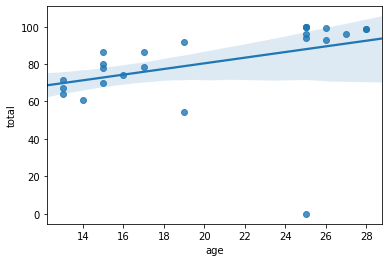

In [11]:
sns.regplot(data = results, x = 'age', y = 'total', fit_reg=True)

In [12]:
from scipy import stats

slope, intercept, r_value, p_value, std_err = stats.linregress(results['age'], results['total'])
print('R^2: {}'.format(r_value**2))
print('# of Participants: {}'.format(results.shape[0]))

R^2: 0.14302872805118716
# of Participants: 24


Reviewing the results of our analysis, we see that there does seem to be a positive correlation between age and results of the questionnaire. Given that we hope to see an increase in scoring as age increases, this appears to prove our predictions. However, our RSE is not very good. This seems to be due to two outliers.

As we previously stated, one participant did not select a single answer in the questionnaire. Given that this did not follow the instructions of the questionnaire, we should remove this outlier.

In [13]:
# Calculate z-scores and remove outliers that are greater than 3 standard deviations from the mean.
# This should validate that there is one outlier that we know of and should only remove this outlier.
z_scores = stats.zscore(results)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
results = results[filtered_entries]

R^2: 0.6854129822560511
# of Participants: 23


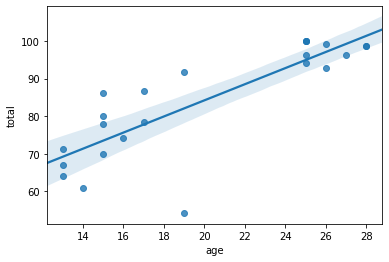

In [14]:
sns.regplot(data = results, x = 'age', y = 'total', fit_reg=True)

slope, intercept, r_value, p_value, std_err = stats.linregress(results['age'], results['total'])
print('R^2: {}'.format(r_value**2))
print('# of Participants: {}'.format(results.shape[0]))

After applying our outlier filter, we can see that there are now 23 participants included rather than our original 24 participants. We see that the data entry that was removed corresponds to the participant we expected to exclude.

We have now achieved an RSE of 0.685. This is still below our 0.7 requirement, but is very close to the result we were looking for. It appears there is still an outlier in the data. We should investigate further to determine if this result is accurate. 

Given only 24 participants so far, we should also survey additional participants to see if the correlation improves.

### Average score per question

Let's briefly look at the average score per question. This may give us additional insight into which questions could be refined to improve the accuracy of our questionnaire in determining knowledge of the subject.

In [16]:
results_by_question = df.groupby(['question'], as_index=False)['score'].agg({'avg_points': 'mean'})
results_by_question

,question,avg_points
0,q10_v2,0.822917
1,q11_v2,0.802083
2,q12_v2,0.895833
3,q13_v2,0.812500
4,q14_v2,0.739583
5,q15_v2,0.958333
6,q16_v2,0.791667
7,q17_v2,0.625000
8,q18_v2,0.833333
9,q19_v2,0.750000
